In [48]:
# Load packages

import webknossos as wk
import matplotlib
import sys, os
import utils
sys.path.append(os.getcwd())
%load_ext autoreload
%autoreload 2

figs_dir = '/Users/atk42/OneDrive - Yale University/Kuan Lab Shared/Projects/TEM_tomo/fig_panels/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Define datasets to analys on WebKnossos
# Should be reconstructons of the exact same volume

my_api_token="YMtdj2_u4T2YQTn5tRHUUg"
my_url = "https://webknossos.org"
organization_id = "8632814cfac2f959"

# These are all same # of projections
datasets = [
    "11_lim15_tomo10a_16bit",
    "15_lim21_tomo10a_16bit",
    "21_lim30_tomo10a_16bit",
    "25_lim36_tomo10a_16bit",
    '31_lim45_tomo10a_16bit',
    "35_lim51_tomo10a_16bit",           
    "41_lim60_tomo10a_16bit",
]

In [9]:
# Download annotation with beads selected
# Should be 1 skeleton with 1 node per bead

with wk.webknossos_context(url=my_url, token=my_api_token):
    annotation_id = 'https://webknossos.org/annotations/683f3db8010000d907dc85a5#1620,701,16,0,0.062,30' #'https://webknossos.org/annotations/680ba75a0100008401cd75bd#1034,1034,95,0,2,21'
    annotation = wk.Annotation.download(annotation_id)

    print(f"Downloaded annotation: {annotation.name}")


Downloaded annotation: 121_lim60_tomo10a_16bit_beads_ATK


In [16]:
# Test opting one dataset
i_dataset = 0
dataset_name = datasets[i_dataset]
print(f"Dataset: {dataset_name}")

with wk.webknossos_context(url=my_url, token=my_api_token):

    dataset = wk.Dataset.open_remote(dataset_name, organization_id=organization_id)
    print(f"Opened dataset: {dataset.name}")
    # 1) Whole-dataset bounding box …
    bbox = dataset.calculate_bounding_box()                # NDBoundingBox of ALL layers :contentReference[oaicite:0]{index=0}
    # 2) …or, for one specific layer:
    # bbox = ds.get_layer("color").bounding_box

    shape_x, shape_y, shape_z = bbox.size       # or: bbox.size_xyz
    print(shape_x, shape_y, shape_z)

Dataset: 11_lim15_tomo10a_16bit
Opened dataset: 11_lim15_tomo10a_16bit
2069 2068 190


In [17]:
annotation_points = utils.get_annotation_points(annotation)
bounding_boxes = utils.compute_bounding_boxes(annotation_points, box_size=32)

subvolumes = utils.download_subvolumes_individually(
    dataset_name=dataset_name,
    bounding_boxes=bounding_boxes,
    api_token=my_api_token,
    organization_id=organization_id,
    webknossos_url=my_url
)


Using layer: 11_lim15_tomo10a_16bit.tif


/Users/atk42/envs/beadres/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

## Download data before first use

In [18]:
from importlib import reload
reload(utils)

for i_dataset in range(len(datasets)):
    dataset_name = datasets[i_dataset]
    print(f"Dataset: {dataset_name}")

    with wk.webknossos_context(url=my_url, token=my_api_token):
        dataset = wk.Dataset.open_remote(dataset_name, organization_id=organization_id)
        print(f"Opened dataset: {dataset.name}")
        bounds = dataset.calculate_bounding_box()              

    annotation_points = utils.get_annotation_points(annotation)
    bounding_boxes = utils.compute_bounding_boxes_flex(annotation_points, box_size=36, dataset_shape=bounds.size)
    #bounding_boxes = utils.compute_bounding_boxes(annotation_points, box_size=36)
    subvolumes = utils.download_subvolumes_individually(
        dataset_name=dataset_name,
        bounding_boxes=bounding_boxes,
        api_token=my_api_token,
        organization_id=organization_id,
        webknossos_url=my_url
    )

    # Save after download
    file_name = f"{dataset_name}.npz"
    utils.save_subvolumes_to_npz(subvolumes, annotation_points, file_name)


Dataset: 11_lim15_tomo10a_16bit
Opened dataset: 11_lim15_tomo10a_16bit
Using layer: 11_lim15_tomo10a_16bit.tif


Saved 58 subvolumes to 11_lim15_tomo10a_16bit.npz
Dataset: 15_lim21_tomo10a_16bit
Opened dataset: 15_lim21_tomo10a_16bit
Using layer: 15_lim21_tomo10a_16bit.tif


Saved 58 subvolumes to 15_lim21_tomo10a_16bit.npz
Dataset: 21_lim30_tomo10a_16bit
Opened dataset: 21_lim30_tomo10a_16bit
Using layer: 21_lim30_tomo10a_16bit.tif


Saved 58 subvolumes to 21_lim30_tomo10a_16bit.npz
Dataset: 25_lim36_tomo10a_16bit
Opened dataset: 25_lim36_tomo10a_16bit
Using layer: 25_lim36_tomo10a_16bit.tif


Saved 58 subvolumes to 25_lim36_tomo10a_16bit.npz
Dataset: 31_lim45_tomo10a_16bit
Opened dataset: 31_lim45_tomo10a_16bit
Using layer: 31_lim45_tomo10a_16bit.tif


Saved 58 subvolumes to 31_lim45_tomo10a_16bit.npz
Dataset: 35_lim51_tomo10a_16bit
Opened dataset: 35_lim51_tomo10a_16bit
Using layer: 35_lim51_tomo10a_16bit.tif


Saved 58 subvolumes to 35_lim51_tomo10a_16bit.npz
Dataset: 41_lim60_tomo10a_16bit
Opened dataset: 41_lim60_tomo10a_16bit
Using layer: 41_lim60_tomo10a_16bit.tif


Saved 58 subvolumes to 41_lim60_tomo10a_16bit.npz


### optionally inspect a few

In [ ]:
# utils.plot_bead_triplet_montage(subvolumes) #, title="Center Slices of Each Bead (Z, Y, X)")


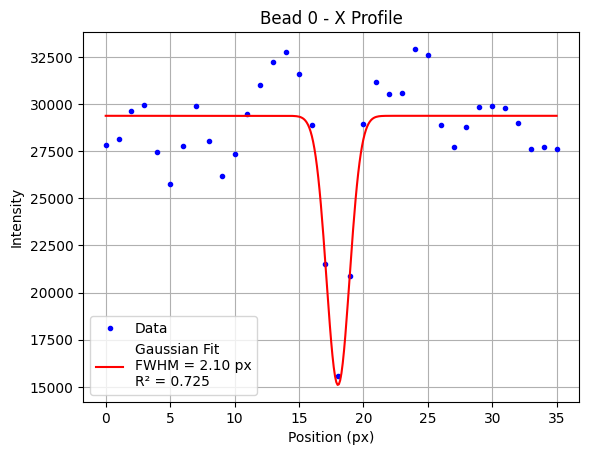

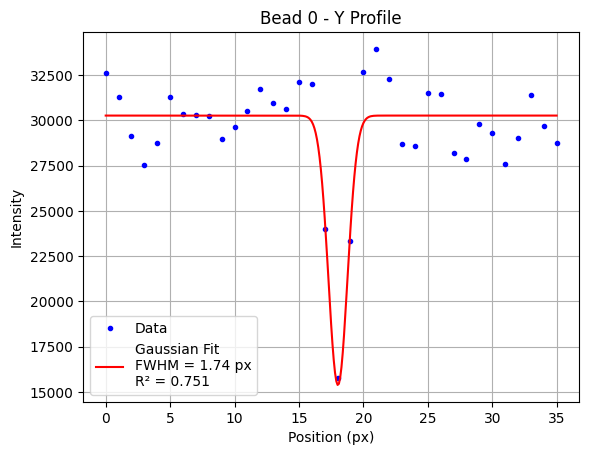

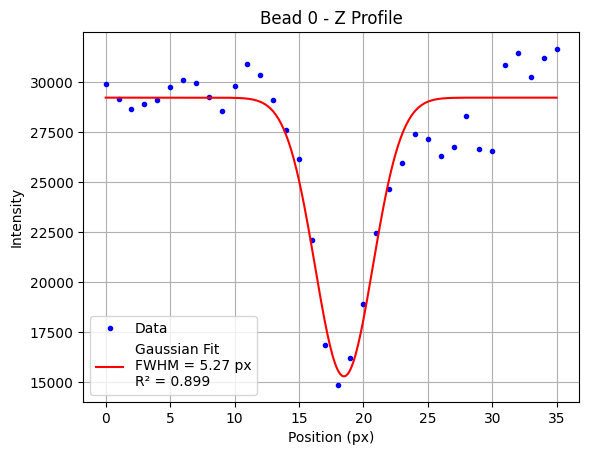

(np.float64(5.272833434372639),
 array([-1.39281058e+04,  1.84933500e+01,  2.23899509e+00,  2.92151557e+04]),
 np.float64(0.8989948091994124))

In [62]:
# Pick a subvolume
vol = subvolumes[1]
z, y, x = vol.shape

profile_z = vol[:, y//2, x//2]
profile_y = vol[z//2, :, x//2]
profile_x = vol[z//2, y//2, :]

# Fit and plot
utils.fit_gaussian_and_compute_fwhm(profile_x, linewidth = 2, plot_fit=True, title="Bead 0 - X Profile")
utils.fit_gaussian_and_compute_fwhm(profile_y, linewidth = 2, plot_fit=True, title="Bead 0 - Y Profile")
utils.fit_gaussian_and_compute_fwhm(profile_z, linewidth = 2, plot_fit=True, title="Bead 0 - Z Profile")


## Now load the pre-downloaded data

In [65]:
subvolumes_list = []

all_fwhms_x, all_fwhms_y, all_fwhms_z = [], [], []
all_2s_x, all_r2s_y, all_r2s_z = [], [], []

for i_dataset, dataset_name in enumerate(datasets):
    print(f"Processing dataset {i_dataset}: {dataset_name}")
    file_name = f"{dataset_name}.npz"
    subvolumes, annotation_points = utils.load_subvolumes_from_npz(file_name)
    subvolumes_list.append(subvolumes)
    fwhms_x, fwhms_y, fwhms_z, r2s_x, r2s_y, r2s_z = utils.compute_fwhms_from_subvolumes(subvolumes, linewidth = 2)

    all_fwhms_x.append(fwhms_x)
    all_fwhms_y.append(fwhms_y)
    all_fwhms_z.append(fwhms_z)

    r2s_z.append(r2s_z)
    r2s_y.append(r2s_y)
    r2s_x.append(r2s_x)


Processing dataset 0: 11_lim15_tomo10a_16bit
Processing dataset 1: 15_lim21_tomo10a_16bit
Processing dataset 2: 21_lim30_tomo10a_16bit


<string>:44: OptimizeWarning: Covariance of the parameters could not be estimated


Processing dataset 3: 25_lim36_tomo10a_16bit
Processing dataset 4: 31_lim45_tomo10a_16bit
Processing dataset 5: 35_lim51_tomo10a_16bit
Processing dataset 6: 41_lim60_tomo10a_16bit


In [66]:
out_x, out_y, out_z = utils.report_fwhm_outliers(all_fwhms_x, all_fwhms_y, all_fwhms_z)


X-axis: mean=6.40, std=72.00, outliers=1
Y-axis: mean=20.37, std=215.25, outliers=3
Z-axis: mean=17.79, std=136.10, outliers=2


In [ ]:
    
# utils.plot_fwhm_outliers(subvolumes_list, all_fwhms_x, 'X', out_x)
# utils.plot_fwhm_outliers(subvolumes_list, all_fwhms_y, 'Y', out_y)
# utils.plot_fwhm_outliers(subvolumes_list, all_fwhms_z, 'Z', out_z)

In [ ]:
# utils.plot_fwhm_outliers_image(subvolumes_list, out_x, axis_label='X')
# utils.plot_fwhm_outliers_image(subvolumes_list, out_y, axis_label='Y')
# utils.plot_fwhm_outliers_image(subvolumes_list, out_z, axis_label='Z')

In [74]:
# Filter in-place: remove FWHM values > 100 from each sublist
all_fwhms_x = [[val for val in sublist if val <= 30] for sublist in all_fwhms_x]
all_fwhms_y = [[val for val in sublist if val <= 30] for sublist in all_fwhms_y]
all_fwhms_z = [[val for val in sublist if val <= 30] for sublist in all_fwhms_z]

# Filter in-place: remove FWHM values < 1 from each sublist
all_fwhms_x = [[val for val in sublist if val >= 1] for sublist in all_fwhms_x]
all_fwhms_y = [[val for val in sublist if val >= 1] for sublist in all_fwhms_y]
all_fwhms_z = [[val for val in sublist if val >= 1] for sublist in all_fwhms_z]


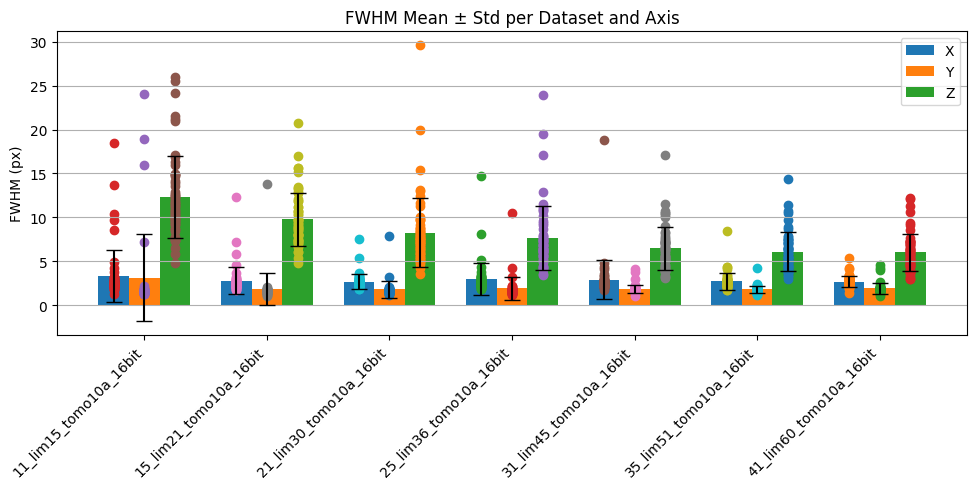

In [75]:
from importlib import reload
reload(utils)
utils.plot_fwhm_summary_by_dataset(all_fwhms_x, all_fwhms_y, all_fwhms_z, dataset_names=datasets)


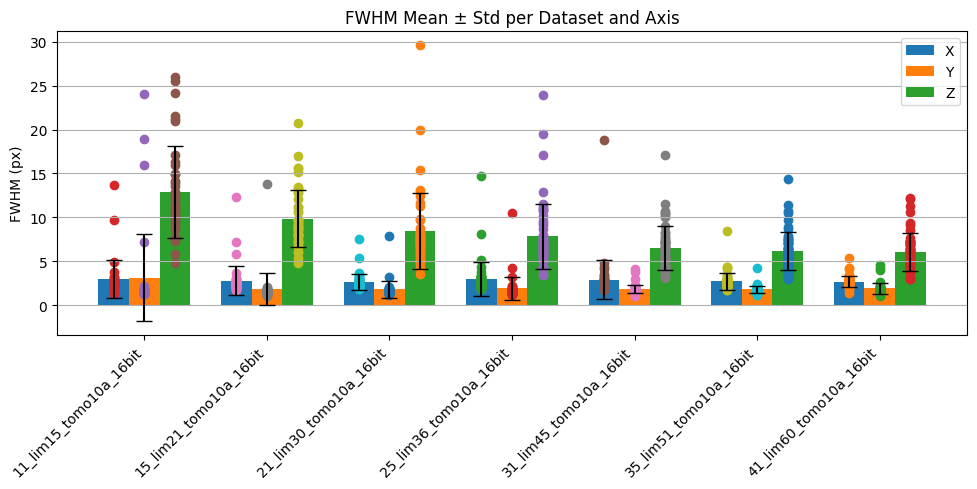

In [76]:
clean_fwhms_x, clean_fwhms_y, clean_fwhms_z = utils.remove_joint_outliers(
    all_fwhms_x, all_fwhms_y, all_fwhms_z, threshold=100.0
)

from importlib import reload
reload(utils)
utils.plot_fwhm_summary_by_dataset(clean_fwhms_x, clean_fwhms_y, clean_fwhms_z, dataset_names=datasets)


In [77]:
# Filter datasets and fwhm lists together to drop empty cases
filtered = [
    (name, fx, fy, fz)
    for name, fx, fy, fz in zip(datasets, all_fwhms_x, all_fwhms_y, all_fwhms_z)
    if len(fx) > 0 and len(fy) > 0 and len(fz) > 0
]

# Unpack filtered lists
datasets, all_fwhms_x, all_fwhms_y, all_fwhms_z = zip(*filtered)


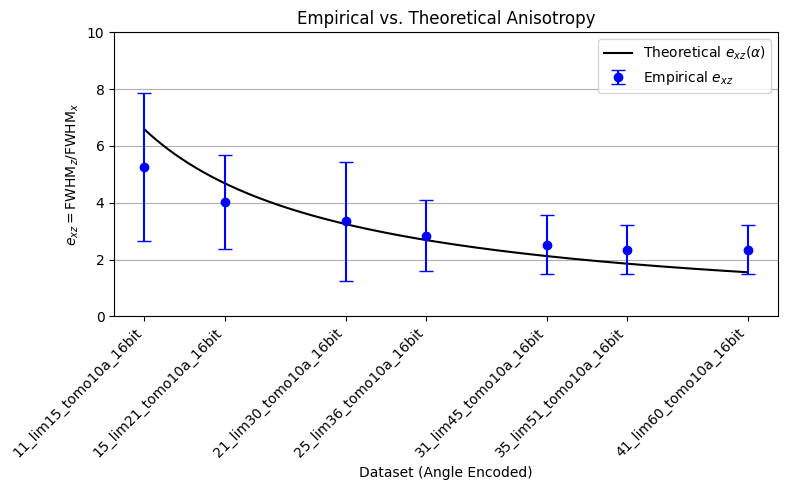

In [78]:
import re
import numpy as np
import matplotlib.pyplot as plt

# Extract angles from dataset names
def extract_angle(name):
    match = re.search(r'lim(\d+)', name)
    return int(match.group(1)) if match else None

angles = [extract_angle(name) for name in datasets]
dataset_labels = datasets

# Compute empirical e_xz for each dataset USING X not Y
e_means = []
e_stds = []

for name in datasets:
    idx = datasets.index(name)
    mean, std = empirical_ratio_and_std(clean_fwhms_z[idx], clean_fwhms_x[idx])
    e_means.append(mean)
    e_stds.append(std)

# Theoretical curve
alpha_curve = np.linspace(15, 60, 300)
e_theory = [calculate_e_xz(a) for a in alpha_curve]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(alpha_curve, e_theory, label='Theoretical $e_{xz}(\\alpha)$', color='black')

# Empirical data
plt.errorbar(
    angles, e_means, yerr=e_stds, fmt='o', capsize=5, markersize=6,
    label='Empirical $e_{xz}$', color='blue'
)

# X-axis with dataset labels at angle ticks
plt.xticks(angles, dataset_labels, rotation=45, ha='right')
plt.xlabel('Dataset (Angle Encoded)')
plt.ylim([0,10])
plt.ylabel(r'$e_{xz} = \mathrm{FWHM}_z / \mathrm{FWHM}_x$')
plt.title('Empirical vs. Theoretical Anisotropy')
plt.legend(loc='upper right')
plt.grid(True, axis='y')
plt.tight_layout()
#plt.show()


plt.savefig(figs_dir + '250620_rev_Fig1g_alt.pdf', bbox_inches = 'tight')

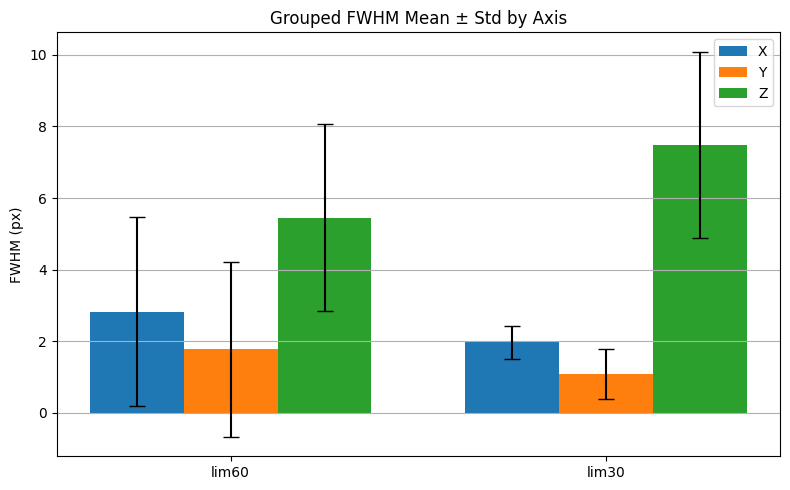

In [ ]:
# group_labels = {
#     'lim60': ['lim60'],
#     'lim30': ['lim30']
# }

# utils.plot_fwhm_summary(
#     all_fwhms_x, all_fwhms_y, all_fwhms_z,
#     dataset_names=datasets,
#     group_labels=group_labels
# )


In [ ]:
fwhms_z = []
fwhms_y = []
fwhms_x = []

for i, vol in enumerate(subvolumes):
    z, y, x = vol.shape

    profile_z = vol[:, y//2, x//2]
    profile_y = vol[z//2, :, x//2]
    profile_x = vol[z//2, y//2, :]

    fwhm_z, _ = utils.fit_gaussian_and_compute_fwhm(profile_z)
    fwhm_y, _ = utils.fit_gaussian_and_compute_fwhm(profile_y)
    fwhm_x, _ = utils.fit_gaussian_and_compute_fwhm(profile_x)

    fwhms_z.append(fwhm_z)
    fwhms_y.append(fwhm_y)
    fwhms_x.append(fwhm_x)


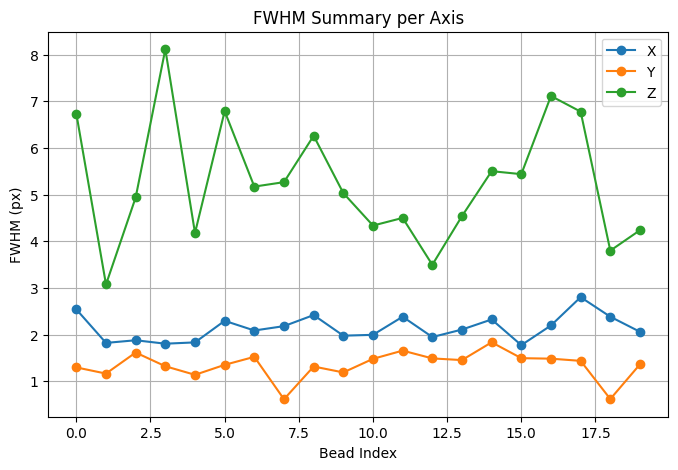

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(fwhms_x, 'o-', label='X')
plt.plot(fwhms_y, 'o-', label='Y')
plt.plot(fwhms_z, 'o-', label='Z')
plt.xlabel('Bead Index')
plt.ylabel('FWHM (px)')
plt.title('FWHM Summary per Axis')
plt.grid(True)
plt.legend()
plt.show()
